<a href="https://colab.research.google.com/github/MithunKiniStar/Recommendation-Systems/blob/main/KNNRecommendationUsingCosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Dataset url: https://grouplens.org/datasets/movielens/latest/

import pandas as pd
import numpy as np

In [4]:
movies_df = pd.read_csv('movies.csv')
movies_df = movies_df[['movieId','title']]
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
rating_df=pd.read_csv('ratings.csv')
rating_df = rating_df[['userId',	'movieId',	'rating']]
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [8]:
df = pd.merge(movies_df,rating_df,on='movieId')
column_names = ["userId", "movieId", "title","rating"]

df = df.reindex(columns=column_names)
df.head()

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,5,1,Toy Story (1995),4.0
2,7,1,Toy Story (1995),4.5
3,15,1,Toy Story (1995),2.5
4,17,1,Toy Story (1995),4.5


In [12]:
# Finding the count of movies watched by user
df.groupby(by = ['userId'])['movieId'].count()
df[df['userId'] == 1].head()

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
325,1,3,Grumpier Old Men (1995),4.0
433,1,6,Heat (1995),4.0
2107,1,47,Seven (a.k.a. Se7en) (1995),5.0
2379,1,50,"Usual Suspects, The (1995)",5.0


In [15]:
df.isnull().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [17]:
# Find the total rating count for each and every movie so that we recommend movies only if the
# total number of rating for a particular movie is above a certain threshold
from pandas.core.groupby import groupby
combine_movie_rating = df.copy()

movie_ratingCount = combine_movie_rating.groupby(by= ['title'])['rating'].count().reset_index().rename(columns = {'rating': 'totalRatingCount'})[['title', 'totalRatingCount']]
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [27]:
# Merging original datframe with movie_ratingCount df
rating_with_totalRatingCount = df.merge(movie_ratingCount, on="title")
rating_with_totalRatingCount.head()

,userId,movieId,title,rating,totalRatingCount
0,1,1,Toy Story (1995),4.0,215
1,5,1,Toy Story (1995),4.0,215
2,7,1,Toy Story (1995),4.5,215
3,15,1,Toy Story (1995),2.5,215
4,17,1,Toy Story (1995),4.5,215


In [22]:
rating_with_totalRatingCount['totalRatingCount'].describe()

count    100836.000000
mean         58.758777
std          61.965384
min           1.000000
25%          13.000000
50%          39.000000
75%          84.000000
max         329.000000
Name: totalRatingCount, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


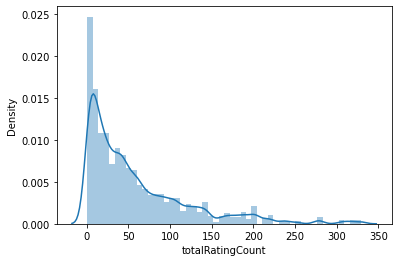

In [21]:
import seaborn as sns
sns.distplot(rating_with_totalRatingCount['totalRatingCount'])

In [24]:
# Fetching popular movies based on rating count above threshold
popularity_threshold = 50
rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41362 entries, 0 to 98317
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userId            41362 non-null  int64  
 1   movieId           41362 non-null  int64  
 2   title             41362 non-null  object 
 3   rating            41362 non-null  float64
 4   totalRatingCount  41362 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.9+ MB


In [30]:
# Create a Pivot table
movie_features_df = rating_popular_movie.pivot_table(index="title", columns="userId", values="rating").fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
28 Days Later (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,5.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0


In [63]:
# csr_matrix is used to convert the table into array matrix
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)
model_knn

NearestNeighbors(algorithm='brute', metric='cosine')

In [38]:
movie_features_df_matrix.shape == movie_features_df.shape

True

In [39]:
# Pick the random index or feature
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)

39


In [46]:
# Converting PD Series to Array
#type(movie_features_df.iloc[query_index,:])
movie_features_array = movie_features_df.iloc[query_index,:].values.reshape(1, -1)

In [50]:
# Model using K Neighbours
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [62]:
# Flatten function will convert array into 1D array
#print(type(distances.flatten()))
print(indices.flatten())

[ 39 386  40 385 320  41]


In [57]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Back to the Future (1985):

1: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 0.329257074458424:
2: Back to the Future Part II (1989), with distance of 0.34343656497489883:
3: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.3456977824846963:
4: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.3558422288395485:
5: Back to the Future Part III (1990), with distance of 0.36176650799954413:


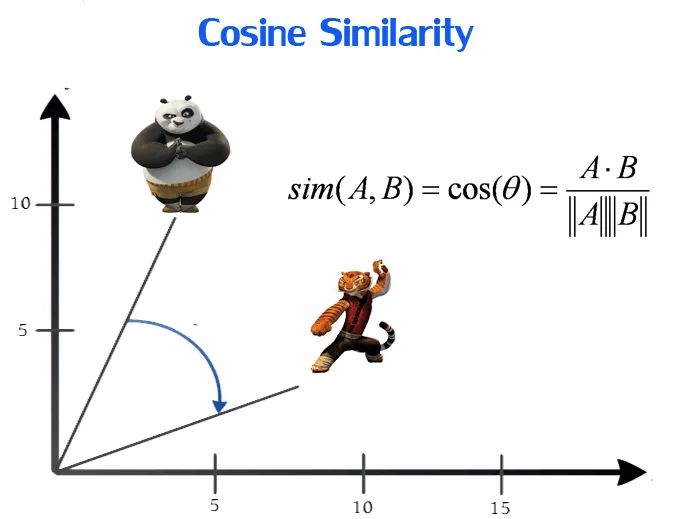